In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import time

# Check for GPU

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Hyperparams

In [3]:
LR = 1e-3 # learning rate
NUM_ITER = 2000 # number iterations

NZ = 512 # input seed dimension
NGF = 256 # number of filters per layer

BS = 1 #batch size
NC = 1 # number of channels

# Grab the data

In [4]:
x_labels = torch.load("/scratch/04703/sravula/UTAFSDataNew/FREQ_VALS.pt")
x_raw = torch.load("/scratch/04703/sravula/UTAFSDataNew/X_RAW.pt")

In [5]:
print(len(x_labels))
print(x_labels[0].shape)

print(len(x_raw))
print(x_raw[0].shape)

1406
torch.Size([1000])
1406
torch.Size([1000, 10, 2])


In [6]:
min_arr = [torch.min(t).item() for t in x_raw]
max_arr = [torch.max(t).item() for t in x_raw]

print("MIN VAL: ", np.min(min_arr))
print("MAX VAL: ", np.max(max_arr))

MIN VAL:  -0.9739965796470642
MAX VAL:  0.9999977946281433


## Looks like there's no need to normalize the data further....

In [7]:
def get_single_series(data, sample_num, chip_num, num_chan):
    """
    Grabs the Real or (Real, Im) series for a single sample and a single chip.
    Output shape is (1, num_chan, L)
    """
    x = data[sample_num][:, chip_num, :] #(LEN, 2)
    
    if num_chan == 1:
        x = x[:, 0].unsqueeze(1) #(LEN, 1)
    
    x = x.unsqueeze(0) #(1, LEN, 1/2)
    x = x.permute(0, 2, 1) #(1, 1/2, LEN)
    
    return x

SAMPLE_IDX = 0
CHIP_IDX = 0

x = get_single_series(x_raw, SAMPLE_IDX, CHIP_IDX, NC)

print(x.shape)

torch.Size([1, 1, 1000])


In [8]:
def get_inds(problem_type, length, num_kept_samples):
    """Given a number of samples to keep and a problem type, returns indices to keep from a list"""
    if problem_type=="random":
        kept_inds = np.random.choice(length, num_kept_samples, replace=False)
    elif problem_type=="equal":
        kept_inds = np.arange(0, length, (length // num_kept_samples))
    elif problem_type=="forecast":
        kept_inds = np.arange(0, num_kept_samples)
    else:
        raise NotImplementedError("THIS PROBLEM TYPE IS UNSUPPORTED")
    
    missing_inds = np.array([t for t in range(length) if t not in kept_inds])
    
    return np.sort(kept_inds), np.sort(missing_inds)

In [9]:
PROBLEM_TYPE = "equal" #[random, equal, forecast]
LENGTH = x.shape[-1]
M = 100

kept_inds, missing_inds = get_inds(PROBLEM_TYPE, LENGTH, M)
M = len(kept_inds)

In [10]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

1000
100
100
900


In [11]:
y = torch.clone(x)[:, :, kept_inds]

print(y.shape)

torch.Size([1, 1, 100])


# Visualize the data and the observations

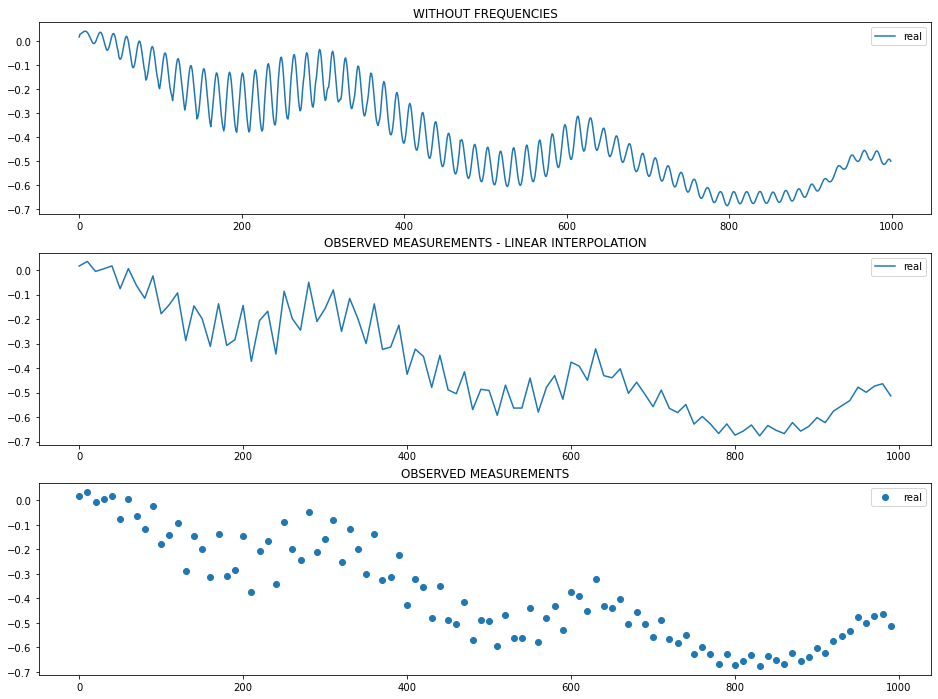

In [12]:
for i in range(BS):
    fig, axes = plt.subplots(3,1, figsize=(16, 12))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("WITHOUT FREQUENCIES")

    axes[1].plot(kept_inds, y[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[1].plot(kept_inds, y[i,1,:].flatten(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("OBSERVED MEASUREMENTS - LINEAR INTERPOLATION")

    axes[2].scatter(kept_inds, y[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[2].scatter(kept_inds, y[i,1,:].flatten(), label="imaginary")
    axes[2].legend()
    axes[2].set_title("OBSERVED MEASUREMENTS")

    plt.show()

# Set up the network

In [13]:
from models import DCGAN, UNET, ENC_DEC

net = ENC_DEC(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC)
net = net.to(device)

In [14]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 1, 1000])


In [15]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  281387776


## Set up and run experiment

In [16]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_mses = []
test_maes = []
outputs = []

x = x.to(device)
y = y.to(device)

In [17]:
from pytorch_wavelets import DWT1DForward
import pywt

def wavelet_mse_loss(x, kept_inds, y, wavelet, alpha):
    mse = nn.MSELoss()(x[:, :, kept_inds], y)
    
    w = pywt.Wavelet(wavelet)
    maxlev = pywt.dwt_max_level(x.shape[-1], w.dec_len)

    dwt = DWT1DForward(J=maxlev, wave=wavelet).to(x.device)

    wl, wh = dwt(x)
    
    wavelet_coeffs = torch.sum(torch.abs(wl))
    for i in range(len(wh)):
        wavelet_coeffs += torch.sum(torch.abs(wh[i]))
    
    return mse + alpha*wavelet_coeffs

In [18]:
WAVELET = 'sym4'
ALPHA_REG = 1.0e-5

LOSS_TYPE = "mse"

if LOSS_TYPE=="mse":
    criterion = lambda x, y: nn.MSELoss()(x[:, :, kept_inds], y)
elif LOSS_TYPE=="mse_wavelet":
    criterion = lambda x, y: wavelet_mse_loss(x, kept_inds, y, WAVELET, ALPHA_REG)

In [19]:
import copy

SMART_RESTART = False

if SMART_RESTART:
    RESTART_WINDOW = 100
    clone_net = None
    restart_idx = 0
    best_train_loss = float('inf')

tic = time.time()
for i in range(NUM_ITER):
    net.perturb_noise() 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        outputs.append(out.detach().clone().cpu())
        train_losses.append(train_loss.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())
        
        if SMART_RESTART:
            bad = (i - restart_idx) > RESTART_WINDOW and \
                  (train_loss.item() > np.max(train_losses[-RESTART_WINDOW:-1]))
            good = train_loss.item() < best_train_loss

            if bad:
                print("BAD: ", str(i))
                restart_idx = i
                net.load_state_dict(clone_net)
            elif good:
                best_train_loss = train_loss.item()
                clone_net = copy.deepcopy(net.state_dict())

        if (i+1)%100 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

ITER  0
TIME:  0.19527792930603027

ITER  99
TIME:  7.621692895889282

ITER  199
TIME:  15.117959022521973

ITER  299
TIME:  22.607648611068726

ITER  399
TIME:  30.099459409713745

ITER  499
TIME:  37.59320044517517

ITER  599
TIME:  45.04305553436279

ITER  699
TIME:  52.4491081237793

ITER  799
TIME:  59.85865139961243

ITER  899
TIME:  67.26963925361633

ITER  999
TIME:  74.6802487373352

ITER  1099
TIME:  82.09053659439087

ITER  1199
TIME:  89.50311064720154

ITER  1299
TIME:  96.91751837730408

ITER  1399
TIME:  104.32985496520996

ITER  1499
TIME:  111.74262928962708

ITER  1599
TIME:  119.15518236160278

ITER  1699
TIME:  126.56972527503967

ITER  1799
TIME:  133.98295331001282

ITER  1899
TIME:  141.39694499969482

ITER  1999
TIME:  148.82161164283752



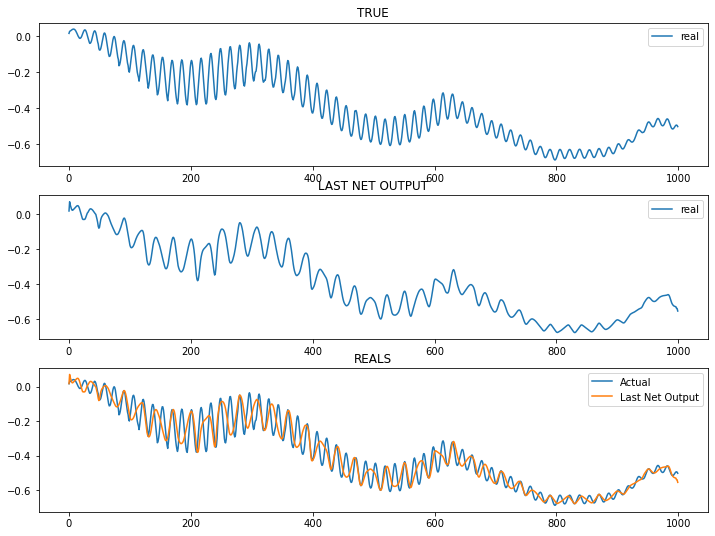

In [20]:
out_last = outputs[-1]

for i in range(BS):
    fig, axes = plt.subplots(NC+2,1, figsize=(12, 9))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("TRUE")

    axes[1].plot(out_last[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[1].plot(out_last[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("LAST NET OUTPUT")

    axes[2].plot(x[i,0,:].flatten().detach().cpu(), label="Actual")
    axes[2].plot(out_last[i,0,:].flatten().detach().cpu(), label="Last Net Output")
    axes[2].legend()
    axes[2].set_title("REALS")

    if NC == 2:
        axes[3].plot(x[i,1,:].flatten().detach().cpu(), label="Actual")
        axes[3].plot(out_last[i,1,:].flatten().detach().cpu(), label="Last Net Output")
        axes[3].legend()
        axes[3].set_title("IMAGINARY")

    plt.show()

BEST TRAIN ITER:  1060


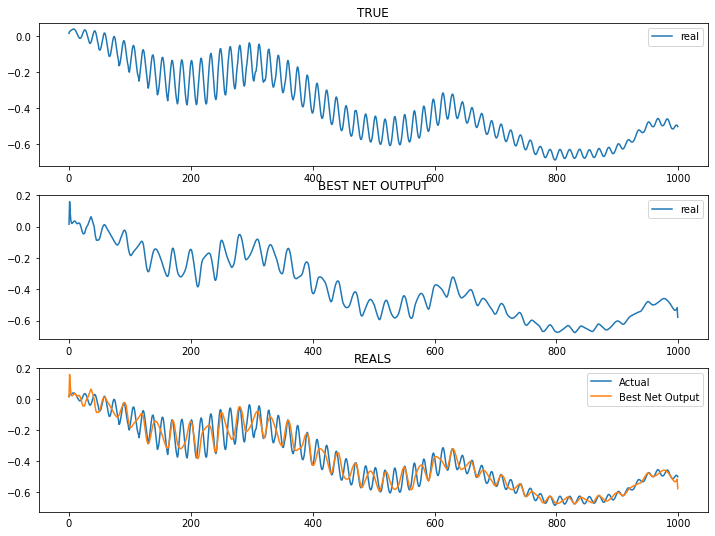

In [21]:
out_best = outputs[np.argmin(train_losses)]
print("BEST TRAIN ITER: ", np.argmin(train_losses))

for i in range(BS):
    fig, axes = plt.subplots(NC+2,1, figsize=(12, 9))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("TRUE")

    axes[1].plot(out_best[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[1].plot(out_best[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("BEST NET OUTPUT")

    axes[2].plot(x[i,0,:].flatten().detach().cpu(), label="Actual")
    axes[2].plot(out_best[i,0,:].flatten().detach().cpu(), label="Best Net Output")
    axes[2].legend()
    axes[2].set_title("REALS")

    if NC == 2:
        axes[3].plot(x[i,1,:].flatten().detach().cpu(), label="Actual")
        axes[3].plot(out_best[i,1,:].flatten().detach().cpu(), label="Best Net Output")
        axes[3].legend()
        axes[3].set_title("IMAGINARY")

    plt.show()

# METRICS

In [22]:
from dtw import *

dtw_list_re = []
if NC == 2:
    dtw_list_im = []
    
for sig in outputs:
    l_dtw_re = dtw(x[0,0,:].detach().cpu().numpy(), sig[0,0,:].flatten().detach().cpu().numpy())
    dtw_list_re.append(l_dtw_re.distance)
    if NC == 2:
        l_dtw_im = dtw(x[0,1,:].detach().cpu().numpy(), sig[0,1,:].flatten().detach().cpu().numpy())
        dtw_list_im.append(l_dtw_im.distance)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



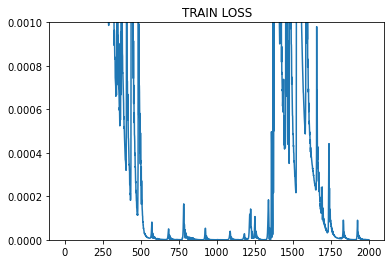

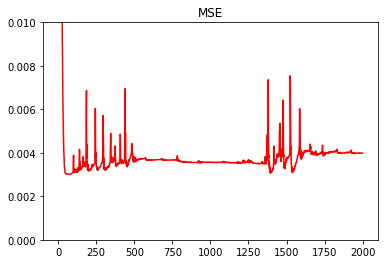

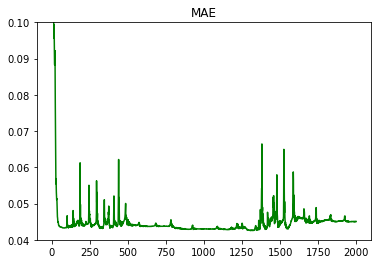

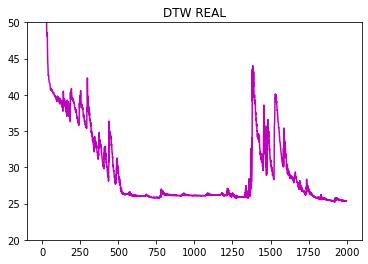

In [23]:
plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., 0.001)
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("MSE")
plt.ylim(0., 0.01)
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("MAE")
plt.ylim(0.04, 0.1)
plt.show()

plt.figure()
plt.plot(dtw_list_re, color='m')
plt.title("DTW REAL")
plt.ylim(20, 50)
plt.show()

if NC == 2:
    plt.figure()
    plt.plot(dtw_list_im)
    plt.title("DTW IMAGINARY")
    plt.ylim(20, 50)
    plt.show()

In [24]:
print("BEST TRAIN LOSS (IDX, VAL): ", np.argmin(train_losses), np.min(train_losses))
print("LAST TRAIN LOSS (VAL): ", train_losses[-1])
print()

print("BEST MSE (IDX, VAL): ", np.argmin(test_mses), np.min(test_mses))
print("LAST MSE (VAL): ", test_mses[-1])
print("TRAIN BEST MSE (VAL): ", test_mses[np.argmin(train_losses)])
print()

print("BEST MAE (IDX, VAL): ", np.argmin(test_maes), np.min(test_maes))
print("LAST MAE (VAL): ", test_maes[-1])
print("TRAIN BEST MAE (VAL): ", test_maes[np.argmin(train_losses)])
print()

print("BEST REAL DTW (IDX, VAL): ", np.argmin(dtw_list_re), np.min(dtw_list_re))
print("LAST REAL DTW (VAL): ", dtw_list_re[-1])
print("TRAIN BEST REAL DTW (VAL): ", dtw_list_re[np.argmin(train_losses)])
print()

if NC==2:
    print("BEST IM DTW (IDX, VAL): ", np.argmin(dtw_list_im), np.min(dtw_list_im))
    print("LAST IM DTW (VAL): ", dtw_list_im[-1])
    print("TRAIN BEST IM DTW (VAL): ", dtw_list_im[np.argmin(train_losses)])

BEST TRAIN LOSS (IDX, VAL):  1060 1.0002751338333837e-07
LAST TRAIN LOSS (VAL):  2.1594590293716465e-07

BEST MSE (IDX, VAL):  75 0.0030099661089479923
LAST MSE (VAL):  0.003992049023509026
TRAIN BEST MSE (VAL):  0.0035583332646638155

BEST MAE (IDX, VAL):  1319 0.04255014285445213
LAST MAE (VAL):  0.045045144855976105
TRAIN BEST MAE (VAL):  0.042965639382600784

BEST REAL DTW (IDX, VAL):  1921 25.18405984860874
LAST REAL DTW (VAL):  25.361477266753354
TRAIN BEST REAL DTW (VAL):  26.092945641838014



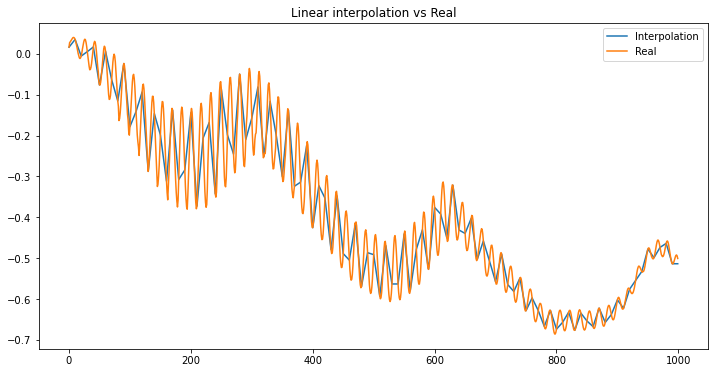

In [25]:
x_int_re = np.interp(np.arange(LENGTH), kept_inds, y[0,0,:].detach().cpu().flatten())
if NC == 2:
    x_int_im = np.interp(np.arange(LENGTH), kept_inds, y[0,1,:].detach().cpu().flatten())

plt.figure(figsize=(12,6))
plt.plot(x_int_re, label="Interpolation")
plt.plot(x[0,0,:].detach().cpu(), label="Real")
plt.legend()
plt.title("Linear interpolation vs Real")
plt.show()

if NC == 2:
    plt.figure(figsize=(12,6))
    plt.plot(x_int_im, label="Interpolation")
    plt.plot(x[0,1,:].detach().cpu(), label="Imaginary")
    plt.legend()
    plt.title("Linear interpolation vs Imaginary")
    plt.show()

In [26]:
if NC == 2:
    sse_re = nn.MSELoss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    sse_im = nn.MSELoss(reduction="sum")(torch.tensor(x_int_im), x[0,1,:].detach().cpu())
    mse_tot = (sse_re + sse_im) / (2*LENGTH)
else:
    sse_re = nn.MSELoss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mse_tot = sse_re / LENGTH

print("LINEAR INTERPOLATION MSE: ", mse_tot.item())
print("DIP MSE (LAST): ", test_mses[-1])
print("DIP MSE (BEST): ", np.min(test_mses))
print("DIP MSE (TRAIN BEST): ", test_mses[np.argmin(train_losses)])

LINEAR INTERPOLATION MSE:  0.002928676191239295
DIP MSE (LAST):  0.003992049023509026
DIP MSE (BEST):  0.0030099661089479923
DIP MSE (TRAIN BEST):  0.0035583332646638155


In [27]:
l_dtw = dtw(x[0,0,:].detach().cpu().numpy(), x_int_re)
print("DTW(INTERPOLATION, REAL)", l_dtw.distance)

print("DTW(DIP, REAL) (LAST)", dtw_list_re[-1])
print("DTW(DIP, REAL) (BEST)", np.min(dtw_list_re))
print("DTW(DIP, REAL) (TRAIN BEST)", dtw_list_re[np.argmin(train_losses)])

if NC == 2:
    print()
    
    l_dtw = dtw(x[0,1,:].detach().cpu().numpy(), x_int_im)
    print("DTW(INTERPOLATION, IMAGINARY)", l_dtw.distance)
    
    print("DTW(DIP, IM) (LAST)", dtw_list_im[-1])
    print("DTW(DIP, IM) (BEST)", np.min(dtw_list_im))
    print("DTW(DIP, IM) (TRAIN BEST)", dtw_list_im[np.argmin(train_losses)])

DTW(INTERPOLATION, REAL) 26.663874298683382
DTW(DIP, REAL) (LAST) 25.361477266753354
DTW(DIP, REAL) (BEST) 25.18405984860874
DTW(DIP, REAL) (TRAIN BEST) 26.092945641838014


In [28]:
if NC == 2:
    mae_re = nn.L1Loss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mae_im = nn.L1Loss(reduction="sum")(torch.tensor(x_int_im), x[0,1,:].detach().cpu())
    mae_tot = (mae_re + mae_im) / (2*LENGTH)
else:
    mae_re = nn.L1Loss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mae_tot = mae_re / LENGTH

print("LINEAR INTERPOLATION MAE: ", mae_tot.item())
print("DIP MAE (LAST): ", test_maes[-1])
print("DIP MAE (BEST): ", np.min(test_maes))
print("DIP MAE (TRAIN BEST): ", test_maes[np.argmin(train_losses)])

LINEAR INTERPOLATION MAE:  0.03875206101809162
DIP MAE (LAST):  0.045045144855976105
DIP MAE (BEST):  0.04255014285445213
DIP MAE (TRAIN BEST):  0.042965639382600784
